### Import dataset


In [1]:
suppressPackageStartupMessages(library(tidyverse))

setwd("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/_m/")
data <- read.csv("features_data.csv")
setwd("~/Documents/jupyter-workplace/laser-anoxia/microglia-morphology/data-processing/parameters-analysis/")


## Exploration

In this **data exploration** section we want to see the "face" of our data and parameters through **data visualization** (*box plots* and *density plots*) and a **statistic description** (*mean*, *median*, *standard deviantion*, *variance*, *max*, *min*, etc).

The parameters description from **_Fraclac_** metrics, used in the follow sections, were checked on the plugin documentation. Details on [_Fraclac glossary_](https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/Glossary.htm) and [_Hull and Circle morphometrics_](https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/hc.htm). As for those parameters from **ImageJ native tools** the description can be checked on [_Analyze_](https://imagej.nih.gov/ij/docs/menus/analyze.html).



### Essential functions

Here below was built a simple function `get.description()` to get a **statistic description** of each parameter. This function is used in the follow function `mount.description()` to **mount a table** for a neatier presentation.

In [2]:
# get a statistic description of the data
get.description <- function(data){ 
    data.description <- as.matrix(summary(data))# statistic summary
    data.description <- t(data.description)     # horizontalize
    data.description <- cbind(data.description, Var = var(data),
                              Sd = sd(data), N = length(data))
    return(as.data.frame(data.description))
}

# mount description table/data-frame
mount.description <- function(data, variable, region = FALSE){
if(region == FALSE){
  groups <- c("CS","AS","AL")
  for(i in groups){
    temp.data <- data %>% 
        filter(Grupo == i) %>% 
        select(variable)
    if(i == "CS"){
        data.description <- cbind(Grupo = i, get.description(temp.data[,1]))
    }
    else{
        temp.description <- cbind(Grupo = i, get.description(temp.data[,1]))
        data.description <- rbind(data.description, temp.description)
    }
  }
  return(data.description)
}
else{
  groups <- c("CS","AS","AL")
  regions <- c("CA1","CA3","GD")
  for(g in groups){
      for(r in regions){
        temp.data <- data %>% 
        filter(Grupo == g & Region == r) %>% 
        select(variable)
        if(g == "CS" & r == "CA1"){
            data.description <- cbind(Grupo = g, Região = r,
                                      get.description(temp.data[,1]))
        }
        else{
            temp.description <- cbind(Grupo = g, Região = r,
                                  get.description(temp.data[,1]))
            data.description <- rbind(data.description, temp.description)
        }
    }
  }
  return(data.description)
  }
}

Here I have two functions `custom.density.plot()` and `custom.box.plot()` with a reproducible *ggplot* setup for a *desity plot* and a *box plot* that will be used for each parameter **data visualization**.

In [3]:
# density plot
custom.density.plot <- function(data,variable, region = FALSE){
  data.id  <- data[,1:4] 
  data.var <- data[variable]
  data     <- cbind(data.id,data.var)
  colnames(data) <- c("Animal","Corte","Grupo","Region","x")
  
  if(region == FALSE){
    p <- ggplot(data,aes(x, fill = Grupo)) +
         geom_density(alpha = 0.7) + xlab(variable) +
         ggtitle(label = "Density plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
  else{
    p <- ggplot(data,aes(x, fill = Grupo)) +
         geom_density(alpha = 0.7) + xlab(variable) +
         ggtitle(label = "Density plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         facet_grid(~Region) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
}

# box plot
custom.box.plot <- function(data,variable, region = FALSE){
  data.id  <- data[,1:4] 
  data.var <- data[variable]
  data     <- cbind(data.id,data.var)
  colnames(data) <- c("Animal","Corte","Grupo","Region","x")
  
  if(region == FALSE){
    p <- ggplot(data,aes(x = Grupo, y = x, fill = Grupo)) +
         geom_boxplot() + ylab(variable) + xlab(NULL) +
         ggtitle(label = "Box plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
  else{
    p <- ggplot(data,aes(x = Grupo, y = x, fill = Grupo)) +
         geom_boxplot() + ylab(variable) + xlab(NULL) +
         ggtitle(label = "Box plot") + labs(fill = "Group") +
         theme(legend.direction ="horizontal", legend.position = "top",
               plot.title = element_text(hjust = 0.5)) +
         facet_grid(~Region) +
         scale_fill_manual(values = c("#d0d0d0","#008080","#f07f13"))
    return(p)
  }
}

And finally the function `multiplot()`, from cookbook-r, was used to present both *density plot* and *box plot* side by side.

In [4]:
# multiplot from cookbook-r
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)
  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

### Foreground Pixels/Hull Area (Density)

$$
  Density = \frac{Foreground Pixels}{ConvexHull Area}
$$

This measure was computed by the **_Fraclac plugin_** from ImageJ. Higher values of this metric is correlated with a **ameboid morphology**. Solidity is a similar measure that could be accessed by the *Shape Descriptors* native in ImageJ software.

#### Hippocampus

Note: Using an external vector in selections is ambiguous.
ℹ Use `all_of(variable)` instead of `variable` to silence this message.
ℹ See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>.
This message is displayed once per session.




| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.289 |  0.510  | 0.632  | 0.652 |  0.776  | 1.065 | 0.032 | 0.180 | 720 |
|  AS   | 0.273 |  0.554  | 0.664  | 0.693 |  0.836  | 1.074 | 0.032 | 0.180 | 720 |
|  AL   | 0.293 |  0.549  | 0.670  | 0.690 |  0.817  | 1.092 | 0.030 | 0.173 | 720 |

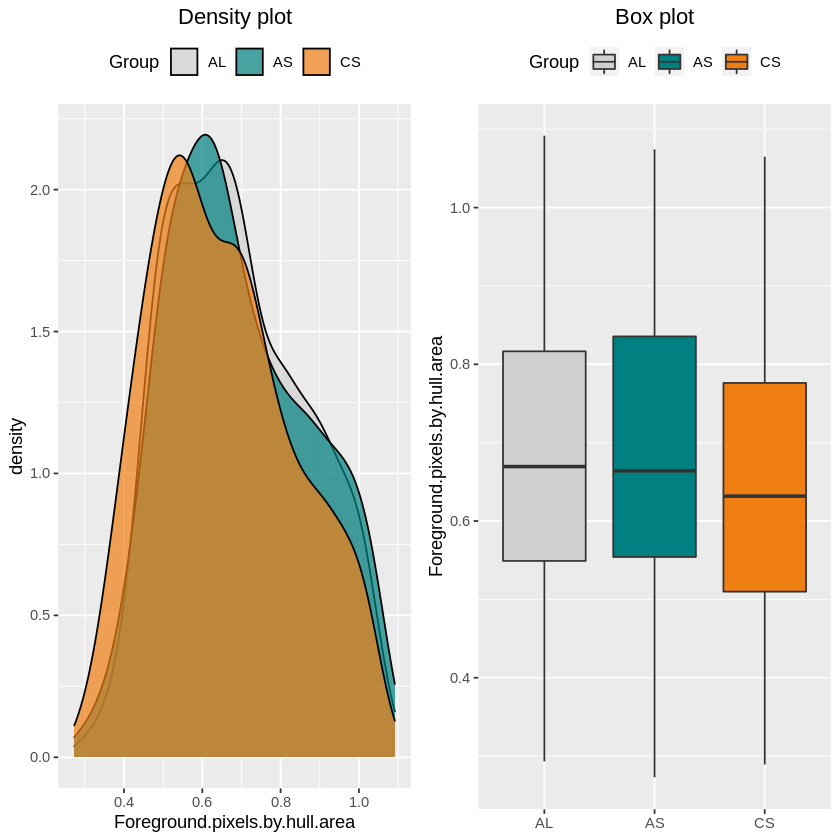

In [5]:
data.description <- mount.description(data, "Foreground.pixels.by.hull.area") 

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))


p1 <- custom.density.plot(data, "Foreground.pixels.by.hull.area")
p2 <- custom.box.plot(data, "Foreground.pixels.by.hull.area")

multiplot(p1,p2,cols = 2)
options(repr.plot.width = 5,repr.plot.width = 10)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.289 |  0.492  | 0.600  | 0.629 |  0.740  | 1.065 | 0.032 | 0.179 | 240 |
|  CS   |  CA3   | 0.307 |  0.504  | 0.638  | 0.641 |  0.767  | 1.038 | 0.031 | 0.175 | 240 |
|  CS   |   GD   | 0.365 |  0.540  | 0.664  | 0.686 |  0.829  | 1.046 | 0.033 | 0.182 | 240 |
|  AS   |  CA1   | 0.273 |  0.541  | 0.662  | 0.683 |  0.799  | 1.074 | 0.032 | 0.180 | 240 |
|  AS   |  CA3   | 0.308 |  0.535  | 0.645  | 0.679 |  0.832  | 1.072 | 0.032 | 0.179 | 240 |
|  AS   |   GD   | 0.361 |  0.578  | 0.686  | 0.717 |  0.865  | 1.061 | 0.032 | 0.179 | 240 |
|  AL   |  CA1   | 0.328 |  0.520  | 0.613  | 0.645 |  0.729  | 1.049 | 0.025 | 0.158 | 240 |
|  AL   |  CA3   | 0.293 |  0.569  | 0.723  | 0.718 |  0.865  | 1.092 | 0.033 | 0.181 | 240 |
|  AL   |   GD   | 0.407 |  0.580  | 0.677  | 0.707 |  0.8

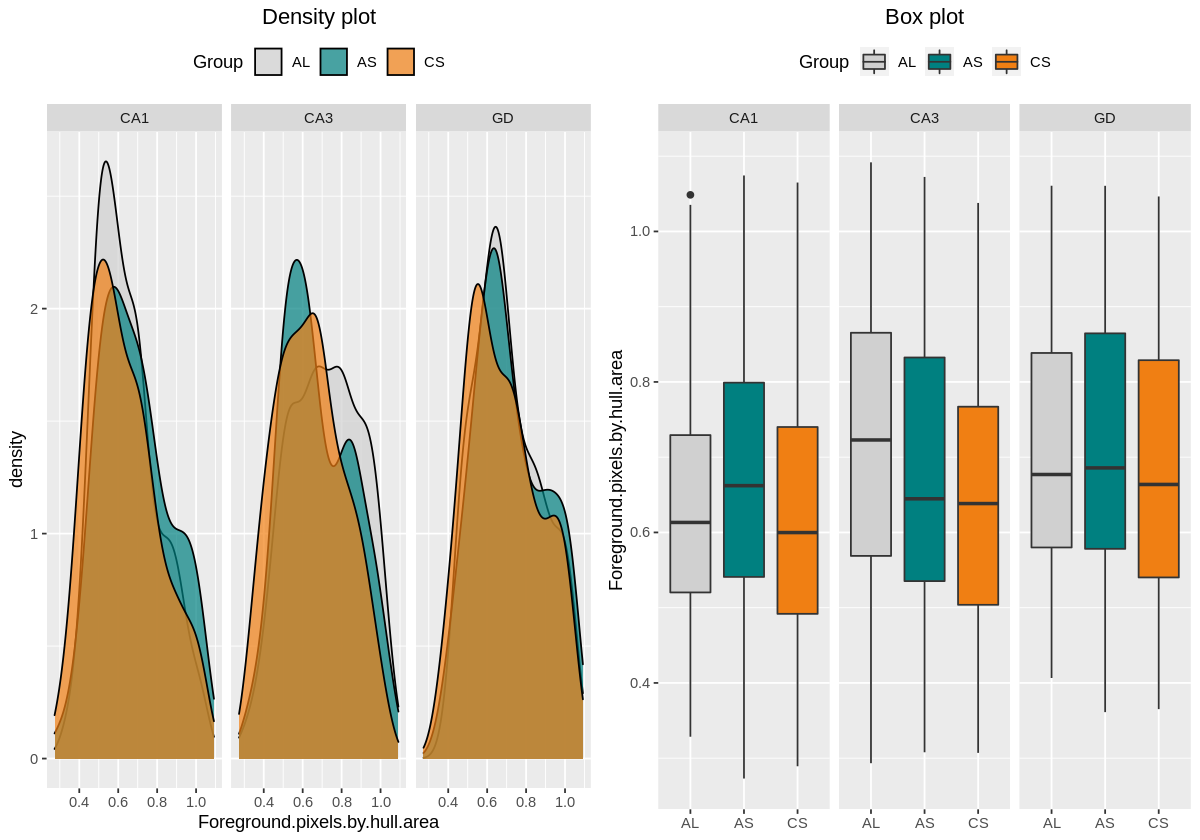

In [6]:
data.description <- mount.description(data, "Foreground.pixels.by.hull.area", 
                                      region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Foreground.pixels.by.hull.area",region = TRUE)
p2 <- custom.box.plot(data,"Foreground.pixels.by.hull.area",region = TRUE)

multiplot(p1,p2,cols = 2)

### Hull Area 
Convex Hull Area was computed by the **_Fraclac plugin_**. This metric measure the area inside a connected series of straight segments that convexly enclosing all foreground pixels of a binary image, as the follow example ilustrate.

<img src='neuronhull.png' width="200" height="200">

#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |   Mean   | 3rd Qu. | Max. |    Var    |    Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:--------:|:-------:|:----:|:---------:|:--------:|:---:|
|  CS   | 163  | 907.00  | 1603.0 | 2012.732 | 2708.50 | 9674 | 2154254.9 | 1467.738 | 720 |
|  AS   | 169  | 816.75  | 1272.5 | 1611.782 | 2120.00 | 6527 | 1205387.5 | 1097.901 | 720 |
|  AL   | 207  | 790.00  | 1223.0 | 1429.769 | 1840.25 | 4755 | 729922.4  | 854.355  | 720 |

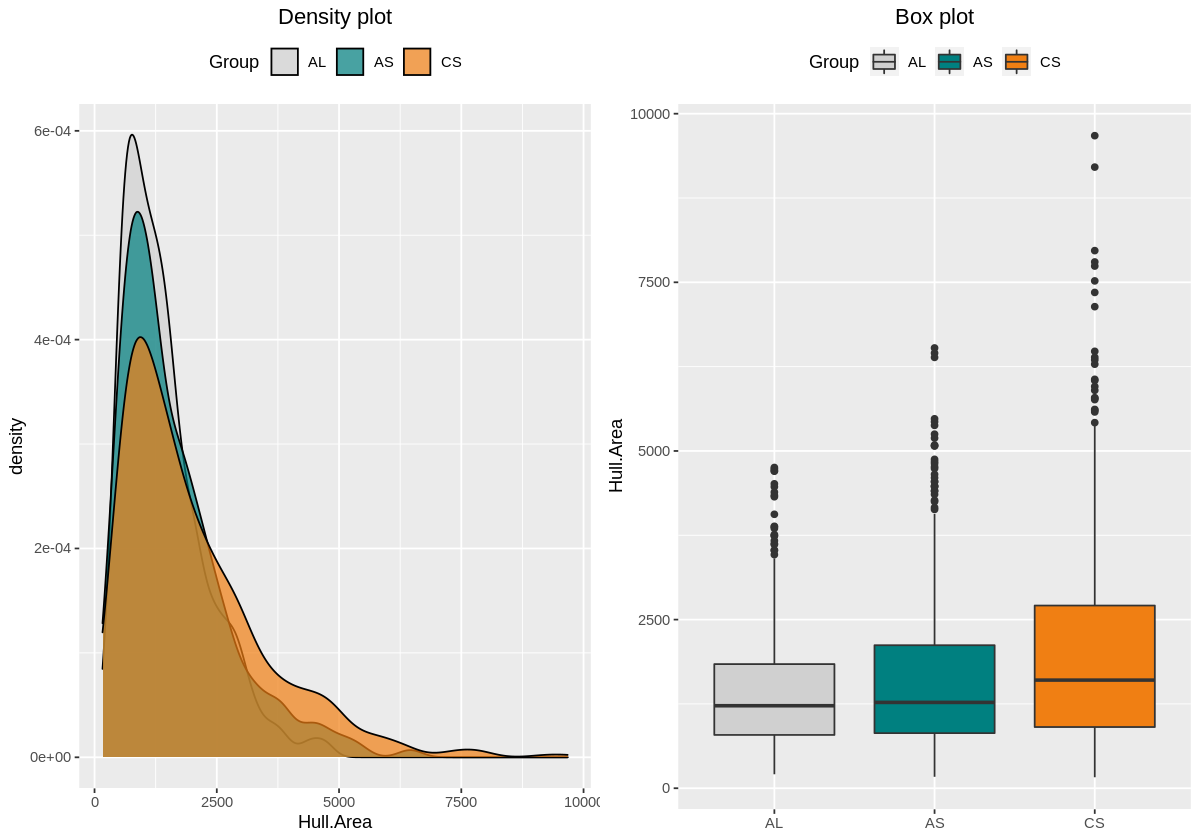

In [7]:
data.description <- mount.description(data, "Hull.Area")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Hull.Area")
p2 <- custom.box.plot(data, "Hull.Area")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |   Mean   | 3rd Qu. | Max. |    Var    |    Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:--------:|:-------:|:----:|:---------:|:--------:|:---:|
|  CS   |  CA1   | 163  | 939.00  | 1690.0 | 2124.492 | 2755.75 | 9674 | 2535685.5 | 1592.384 | 240 |
|  CS   |  CA3   | 231  | 981.75  | 1690.5 | 2115.779 | 2905.25 | 7970 | 2167027.1 | 1472.083 | 240 |
|  CS   |   GD   | 262  | 816.50  | 1439.5 | 1797.925 | 2419.25 | 7521 | 1708538.7 | 1307.111 | 240 |
|  AS   |  CA1   | 215  | 846.00  | 1347.0 | 1708.429 | 2274.25 | 6527 | 1369474.2 | 1170.245 | 240 |
|  AS   |  CA3   | 221  | 826.75  | 1300.5 | 1653.388 | 2124.25 | 6451 | 1269551.3 | 1126.744 | 240 |
|  AS   |   GD   | 169  | 778.50  | 1180.0 | 1473.529 | 1993.75 | 6387 | 956912.1  | 978.219  | 240 |
|  AL   |  CA1   | 286  | 924.75  | 1405.5 | 1620.267 | 2057.00 | 4755 | 867082.5  | 931.173  | 240 |
|  AL   |  CA3   | 207  | 734.50  | 1115.5 | 1356.083 | 1685.00 | 4513 | 739102.

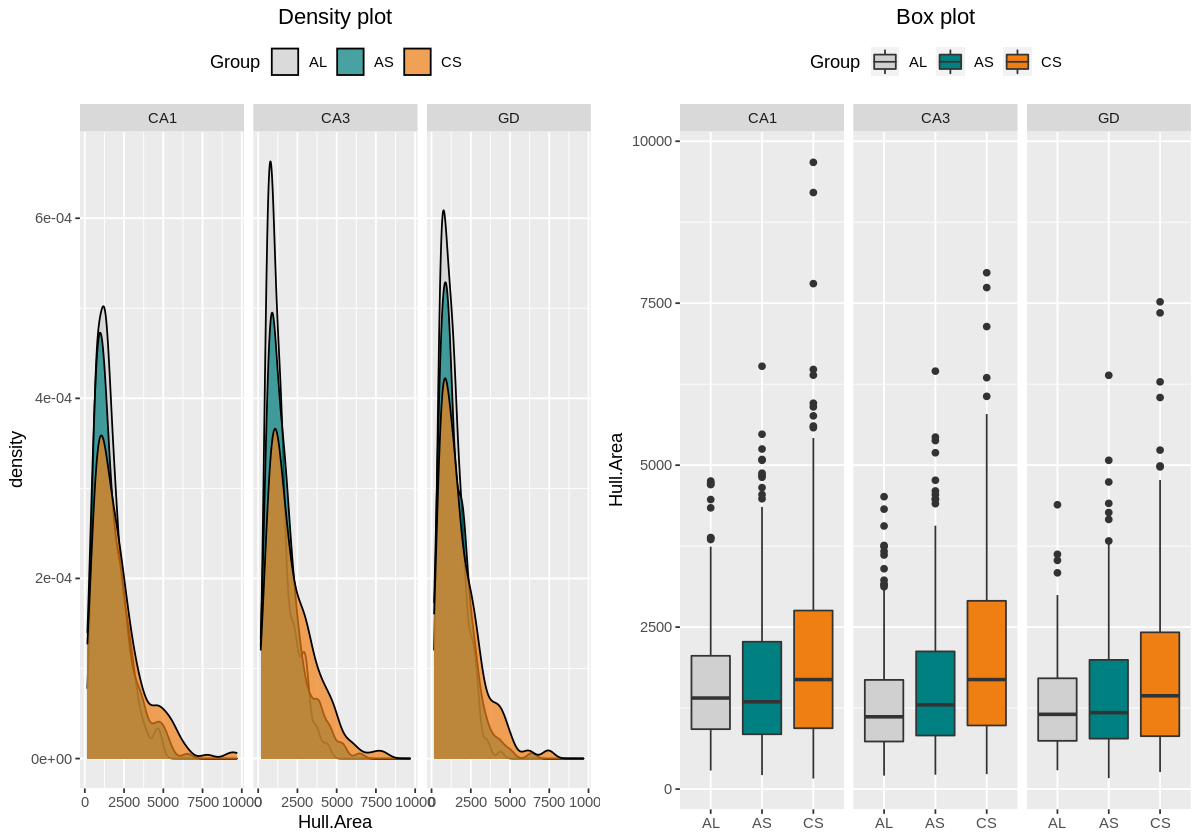

In [8]:
data.description <- mount.description(data, "Hull.Area", region = TRUE) 

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Hull.Area", region = TRUE)
p2 <- custom.box.plot(data, "Hull.Area", region = TRUE)

multiplot(p1,p2,cols = 2)

### Diameter of Bounding Circle
The Diameter of Bouding Circle was measured by Fraclac plugin. As mentioned in [Fraclac glossary](https://imagej.nih.gov/ij/plugins/fraclac/FLHelp/Glossary.htm#circ), this metric compute the diameter of *the smallest circle enclosing all of the foreground pixels of a binary image, calculated using the maximum span across or else the three points defining the smallest circle around the convex hull.*

<img src='neuroncircle.png' width="200" height="200">

#### Hippocampus

In [ ]:
data.description <- mount.description(data, "Diameter.of.Bounding.Circle")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Diameter.of.Bounding.Circle")
p2 <- custom.box.plot(data, "Diameter.of.Bounding.Circle")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Diameter.of.Bounding.Circle", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Diameter.of.Bounding.Circle", region = TRUE)
p2 <- custom.box.plot(data, "Diameter.of.Bounding.Circle", region = TRUE)

multiplot(p1,p2,cols = 2)

### Mean Radius
The Mean Radius was computed by the **_Fraclac plugin_**. This metric *measure the mean length in pixels from the centre of mass of the convex hull to an exterior point*. 

<img src='meanradius.png' width="150" height="150">


#### Hippocampus

In [ ]:
data.description <- mount.description(data, "Mean.Radius")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Mean.Radius")
p2 <- custom.box.plot(data, "Mean.Radius")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Mean.Radius", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Mean.Radius", region = TRUE)
p2 <- custom.box.plot(data, "Mean.Radius", region = TRUE)

multiplot(p1,p2,cols = 2)

### Hull Void Area
A description of the parameter.

<img src='neuronvoidhull.png' width="200" height="200">



#### Hippocampus

In [ ]:
data.description <- mount.description(data,"Hull.void.area")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Hull.void.area")
p2 <- custom.box.plot(data, "Hull.void.area")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Hull.void.area", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Hull.void.area", region = TRUE)
p2 <- custom.box.plot(data, "Hull.void.area", region = TRUE)

multiplot(p1,p2,cols = 2)

### Cell Area
This measure was computed by the native tools from ImageJ software in `Analyze > Set Measurements`.

#### Hippocampus

In [ ]:
data.description <- mount.description(data,"Cell.Area")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Cell.Area")
p2 <- custom.box.plot(data, "Cell.Area")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Cell.Area", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Cell.Area", region = TRUE)
p2 <- custom.box.plot(data, "Cell.Area", region = TRUE)

multiplot(p1,p2,cols = 2)

### Cell Perimeter
This measure was computed by the native tools from ImageJ software in `Analyze > Set Measurements`.

#### Hippocampus

In [ ]:
data.description <- mount.description(data,"Cell.Perimeter")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Cell.Perimeter")
p2 <- custom.box.plot(data, "Cell.Perimeter")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Cell.Perimeter", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Cell.Perimeter", region = TRUE)
p2 <- custom.box.plot(data, "Cell.Perimeter", region = TRUE)

multiplot(p1,p2,cols = 2)

### Solidity
$$
  Solidity = \frac{Cell Area}{Convex Hull Area}
$$

As previously metioned, this measure is similar to **Density** and was computed by the native tools from ImageJ software in `Analyze > Set Measurements > Shape Descriptors`.

#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.278 |  0.485  | 0.591  | 0.607 |  0.714  | 0.953 | 0.025 | 0.158 | 720 |
|  AS   | 0.263 |  0.525  | 0.622  | 0.642 |  0.761  | 0.957 | 0.024 | 0.155 | 720 |
|  AL   | 0.281 |  0.518  | 0.619  | 0.638 |  0.751  | 0.966 | 0.023 | 0.150 | 720 |

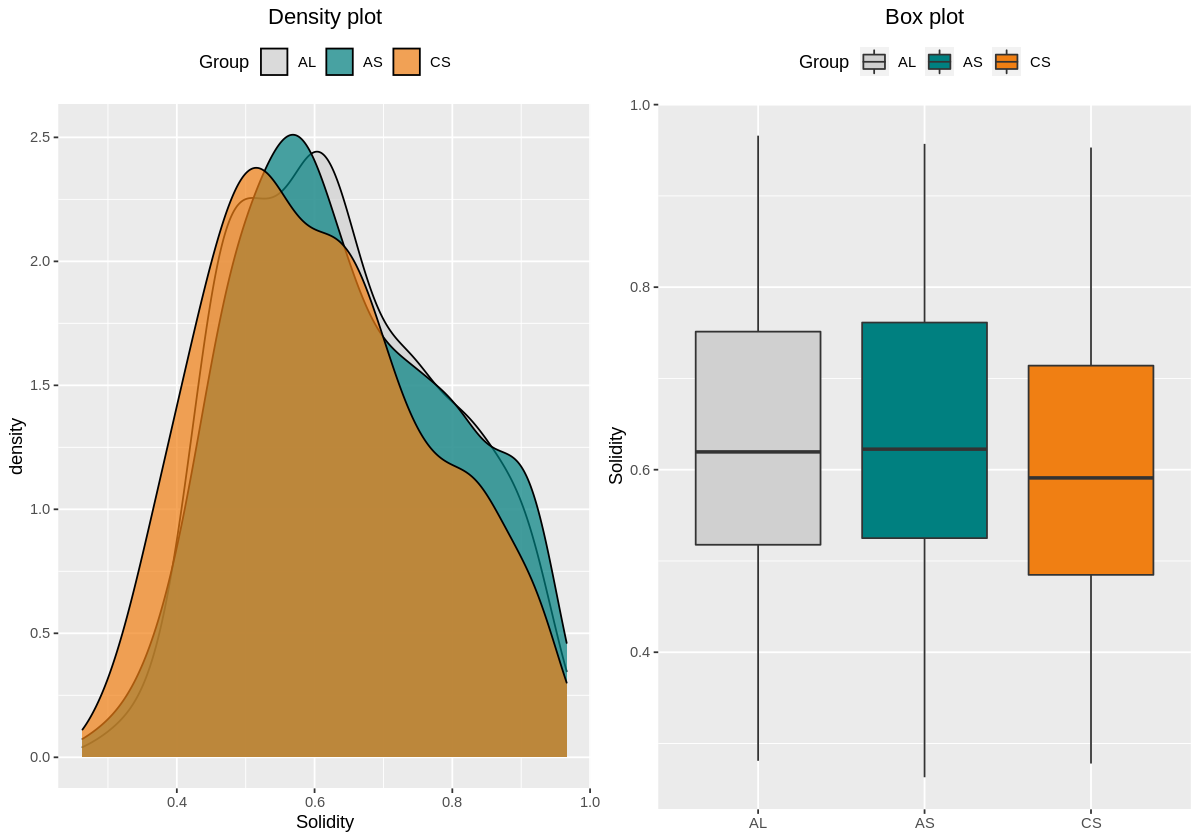

In [19]:
data.description <- mount.description(data,"Solidity")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Solidity")
p2 <- custom.box.plot(data, "Solidity")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.278 |  0.460  | 0.565  | 0.586 |  0.682  | 0.945 | 0.024 | 0.156 | 240 |
|  CS   |  CA3   | 0.294 |  0.475  | 0.595  | 0.598 |  0.712  | 0.953 | 0.024 | 0.154 | 240 |
|  CS   |   GD   | 0.345 |  0.508  | 0.621  | 0.637 |  0.760  | 0.950 | 0.025 | 0.158 | 240 |
|  AS   |  CA1   | 0.263 |  0.514  | 0.619  | 0.634 |  0.742  | 0.942 | 0.024 | 0.156 | 240 |
|  AS   |  CA3   | 0.298 |  0.507  | 0.600  | 0.630 |  0.760  | 0.957 | 0.024 | 0.156 | 240 |
|  AS   |   GD   | 0.349 |  0.546  | 0.640  | 0.662 |  0.791  | 0.950 | 0.023 | 0.153 | 240 |
|  AL   |  CA1   | 0.316 |  0.486  | 0.578  | 0.599 |  0.678  | 0.941 | 0.019 | 0.138 | 240 |
|  AL   |  CA3   | 0.281 |  0.534  | 0.670  | 0.662 |  0.794  | 0.962 | 0.025 | 0.157 | 240 |
|  AL   |   GD   | 0.382 |  0.544  | 0.631  | 0.653 |  0.7

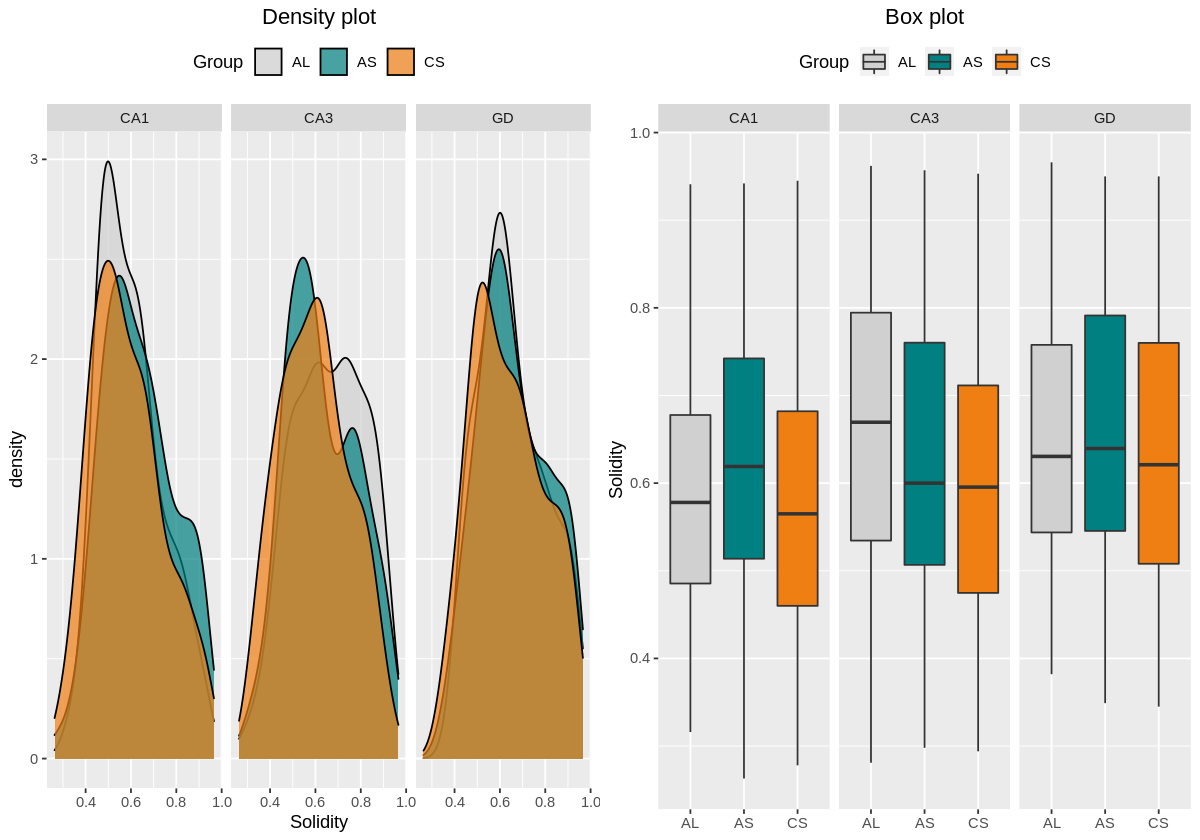

In [20]:
data.description <- mount.description(data, "Solidity", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Solidity", region = TRUE)
p2 <- custom.box.plot(data, "Solidity", region = TRUE)

multiplot(p1,p2,cols = 2)

### Roundness

$$
  Roundness = \frac{{4}*{CellArea}}{{\pi}*{MajorAxis^2}}
$$

This measure was computed by the native tools from ImageJ software in `Analyze > Set Measurements > Shape Descriptors`.

#### Hippocampus

In [ ]:
data.description <- mount.description(data,"Round")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Round")
p2 <- custom.box.plot(data, "Round")

multiplot(p1,p2,cols = 2)


#### Regions

In [ ]:
data.description <- mount.description(data, "Round", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Round", region = TRUE)
p2 <- custom.box.plot(data, "Round", region = TRUE)

multiplot(p1,p2,cols = 2)

### Circularity
$$
  Circularity = \frac{{4\pi}*{CellArea}}{Perimeter^2}
$$

This measure was computed by the native tools from ImageJ software in `Analyze > Set Measurements > Shape Descriptors`.

#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   | 0.038 |  0.125  | 0.212  | 0.274 |  0.379  | 0.902 | 0.039 | 0.198 | 720 |
|  AS   | 0.050 |  0.151  | 0.245  | 0.315 |  0.438  | 0.892 | 0.046 | 0.214 | 720 |
|  AL   | 0.049 |  0.152  | 0.244  | 0.311 |  0.424  | 0.922 | 0.041 | 0.203 | 720 |

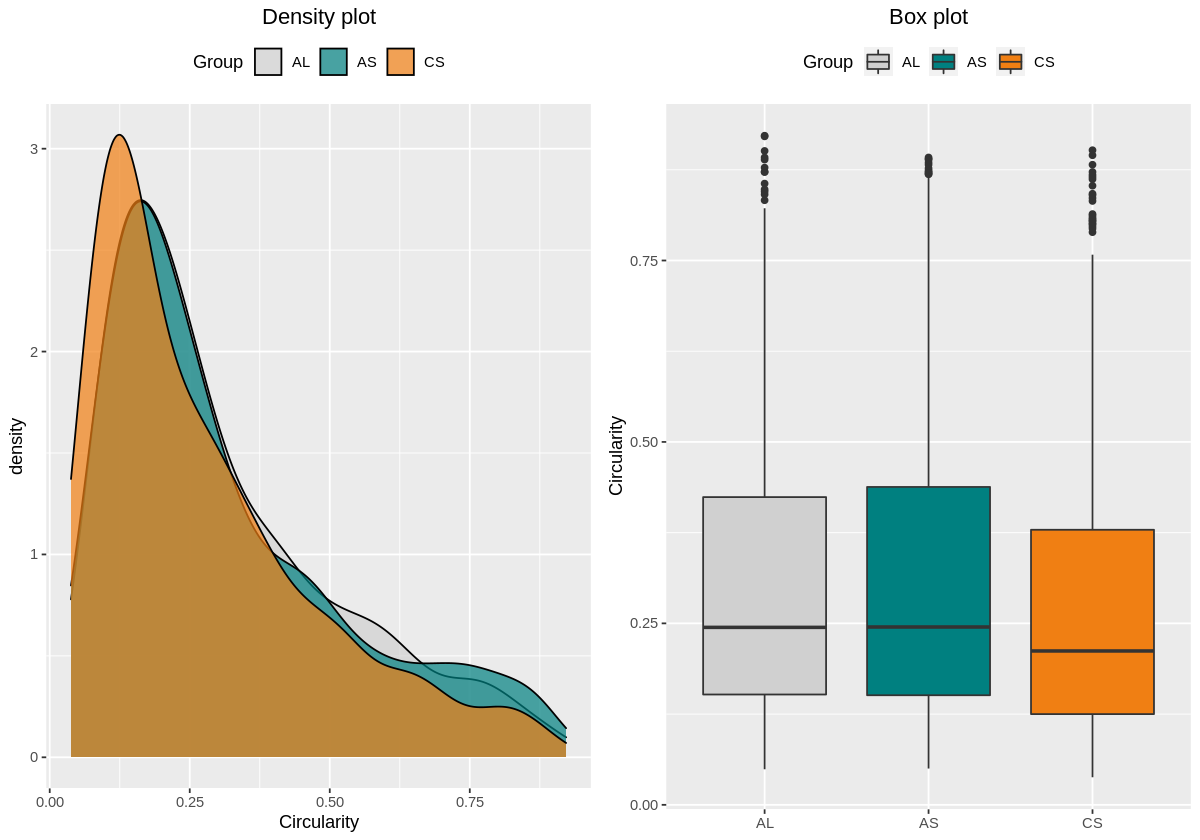

In [23]:
data.description <- mount.description(data,"Circularity")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Circularity")
p2 <- custom.box.plot(data, "Circularity")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median | Mean  | 3rd Qu. | Max.  |  Var  |  Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:-----:|:-------:|:-----:|:-----:|:-----:|:---:|
|  CS   |  CA1   | 0.038 |  0.114  | 0.192  | 0.252 |  0.342  | 0.865 | 0.036 | 0.189 | 240 |
|  CS   |  CA3   | 0.040 |  0.129  | 0.223  | 0.270 |  0.383  | 0.902 | 0.033 | 0.180 | 240 |
|  CS   |   GD   | 0.039 |  0.132  | 0.236  | 0.301 |  0.414  | 0.895 | 0.048 | 0.220 | 240 |
|  AS   |  CA1   | 0.050 |  0.144  | 0.240  | 0.304 |  0.424  | 0.885 | 0.044 | 0.209 | 240 |
|  AS   |  CA3   | 0.053 |  0.148  | 0.243  | 0.305 |  0.435  | 0.892 | 0.042 | 0.204 | 240 |
|  AS   |   GD   | 0.054 |  0.160  | 0.250  | 0.337 |  0.462  | 0.890 | 0.052 | 0.227 | 240 |
|  AL   |  CA1   | 0.051 |  0.133  | 0.207  | 0.252 |  0.309  | 0.833 | 0.028 | 0.168 | 240 |
|  AL   |  CA3   | 0.069 |  0.177  | 0.302  | 0.351 |  0.508  | 0.921 | 0.043 | 0.208 | 240 |
|  AL   |   GD   | 0.049 |  0.164  | 0.248  | 0.329 |  0.4

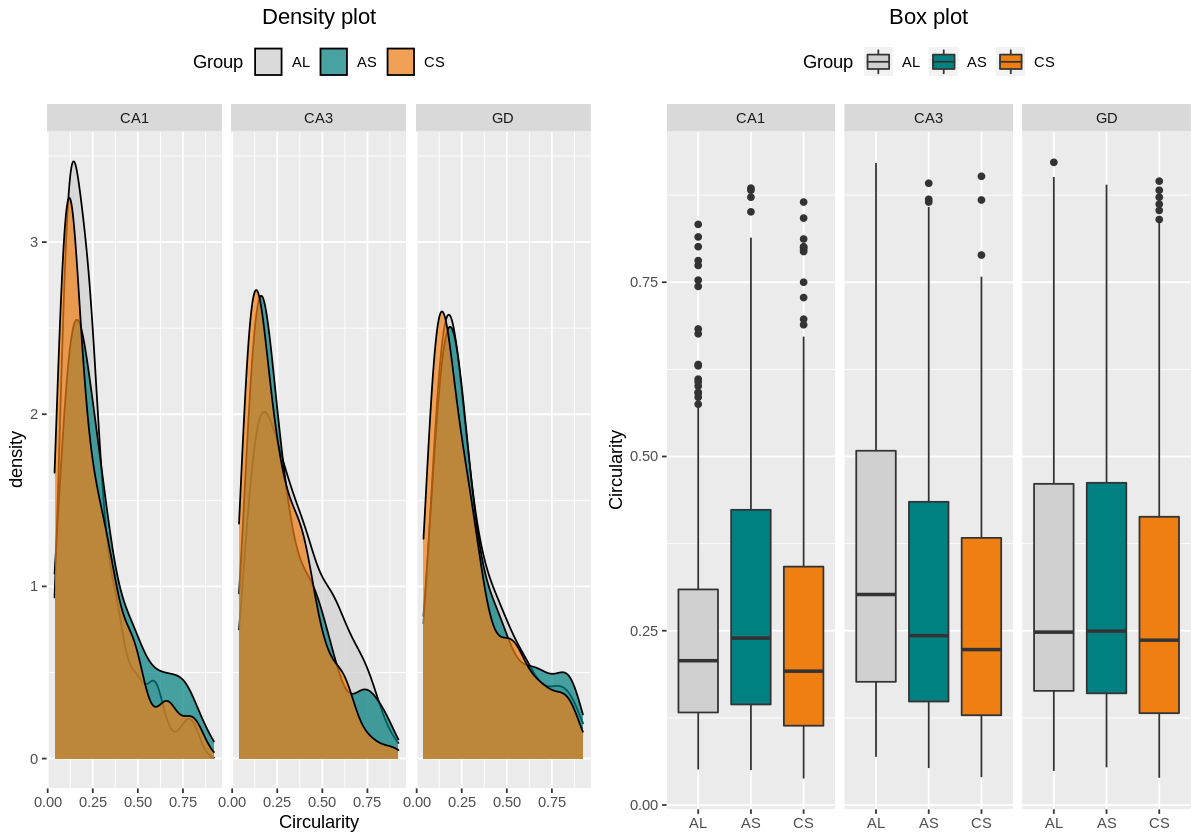

In [24]:
data.description <- mount.description(data, "Circularity", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Circularity", region = TRUE)
p2 <- custom.box.plot(data, "Circularity", region = TRUE)

multiplot(p1,p2,cols = 2)

### Branches
A description of the parameter.

#### Hippocampus

In [ ]:
data.description <- mount.description(data,"Branches")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Branches")
p2 <- custom.box.plot(data, "Branches")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Branches", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Branches", region = TRUE)
p2 <- custom.box.plot(data, "Branches", region = TRUE)

multiplot(p1,p2,cols = 2)

### Junctions
A description of the parameter.

#### Hippocampus

In [ ]:
data.description <- mount.description(data,"Junctions") 

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Junctions")
p2 <- custom.box.plot(data, "Junctions")

multiplot(p1,p2,cols = 2)

#### Regions

In [ ]:
data.description <- mount.description(data, "Junctions", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Junctions", region = TRUE)
p2 <- custom.box.plot(data, "Junctions", region = TRUE)

multiplot(p1,p2,cols = 2)

### Triple Points
A description of the parameter.

#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  0   |    2    |   4    | 5.286 |    7    |  36  | 24.675 | 4.967 | 720 |
|  AS   |  0   |    1    |   3    | 4.194 |    6    |  24  | 15.423 | 3.927 | 720 |
|  AL   |  0   |    1    |   3    | 3.721 |    5    |  17  | 10.274 | 3.205 | 720 |

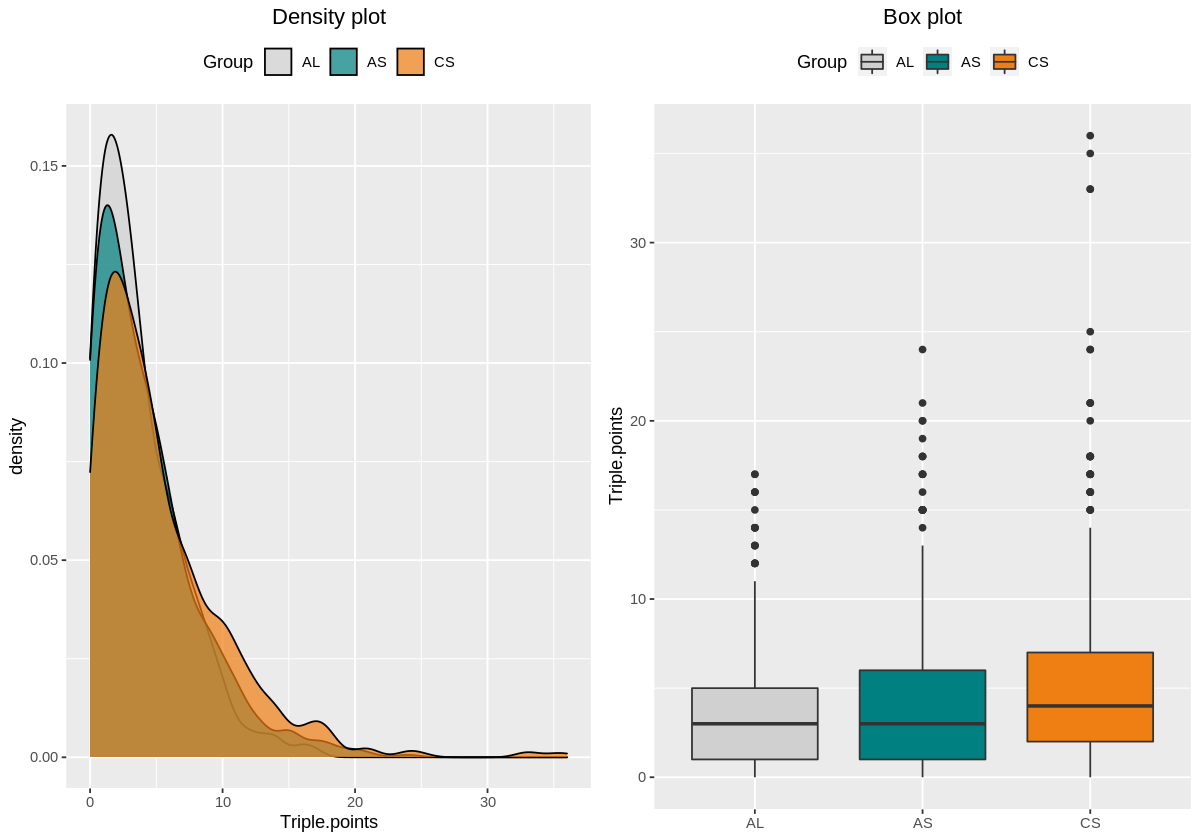

In [29]:
data.description <- mount.description(data,"Triple.points")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Triple.points")
p2 <- custom.box.plot(data, "Triple.points")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  CA1   |  0   |    2    |   4    | 5.679 |  8.00   |  35  | 29.156 | 5.400 | 240 |
|  CS   |  CA3   |  0   |    2    |   4    | 5.125 |  7.25   |  24  | 18.043 | 4.248 | 240 |
|  CS   |   GD   |  0   |    2    |   4    | 5.054 |  7.00   |  36  | 26.796 | 5.177 | 240 |
|  AS   |  CA1   |  0   |    1    |   3    | 4.458 |  6.00   |  24  | 19.002 | 4.359 | 240 |
|  AS   |  CA3   |  0   |    1    |   3    | 4.175 |  6.00   |  18  | 14.438 | 3.800 | 240 |
|  AS   |   GD   |  0   |    1    |   3    | 3.950 |  6.00   |  20  | 12.826 | 3.581 | 240 |
|  AL   |  CA1   |  0   |    2    |   4    | 4.692 |  7.00   |  17  | 13.168 | 3.629 | 240 |
|  AL   |  CA3   |  0   |    1    |   2    | 3.050 |  4.00   |  14  | 8.090  | 2.844 | 240 |
|  AL   |   GD   |  0   |    1    |   3    | 3.421 |  5.00   |  17  

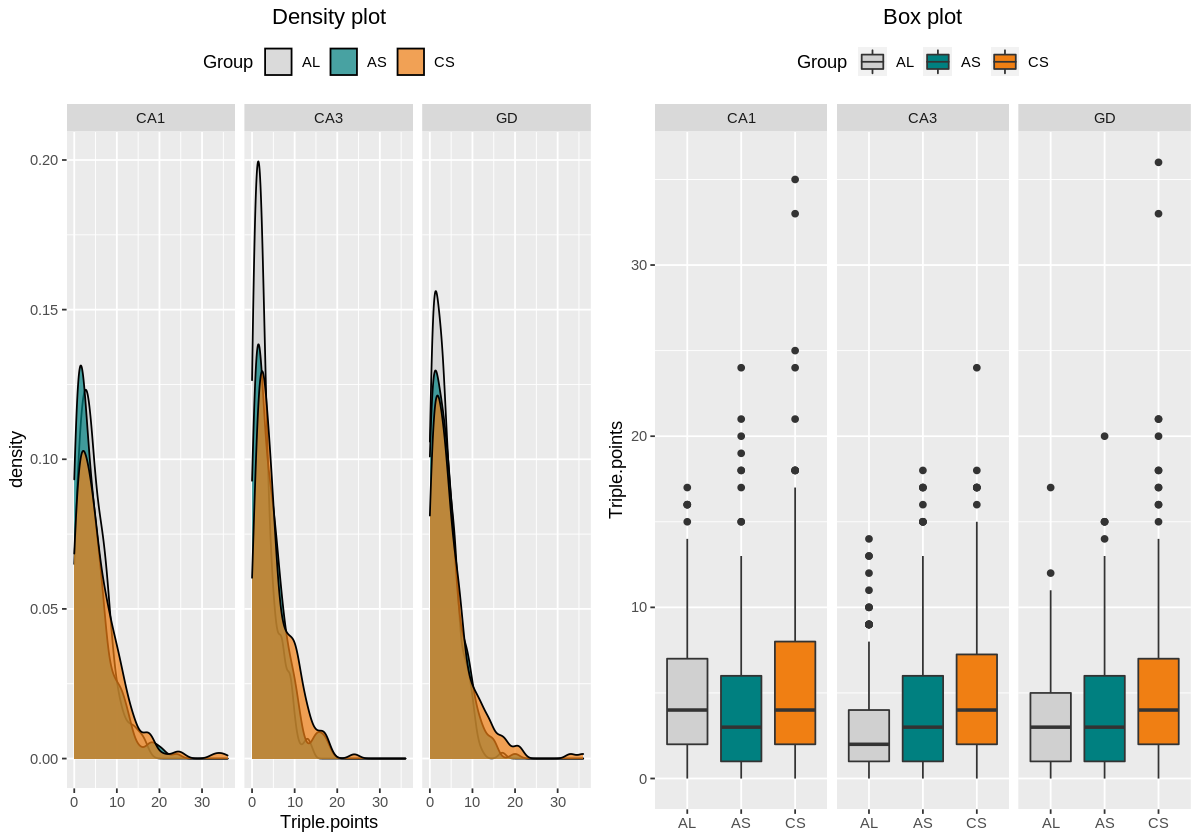

In [30]:
data.description <- mount.description(data, "Triple.points", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Triple.points", region = TRUE)
p2 <- custom.box.plot(data, "Triple.points", region = TRUE)

multiplot(p1,p2,cols = 2)

### Quadruple Points
A description of the parameter.

#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var  |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:-----:|:-----:|:---:|
|  CS   |  0   |    0    |   0    | 0.636 |    1    |  8   | 1.038 | 1.019 | 720 |
|  AS   |  0   |    0    |   0    | 0.525 |    1    |  6   | 0.742 | 0.861 | 720 |
|  AL   |  0   |    0    |   0    | 0.461 |    1    |  5   | 0.613 | 0.783 | 720 |

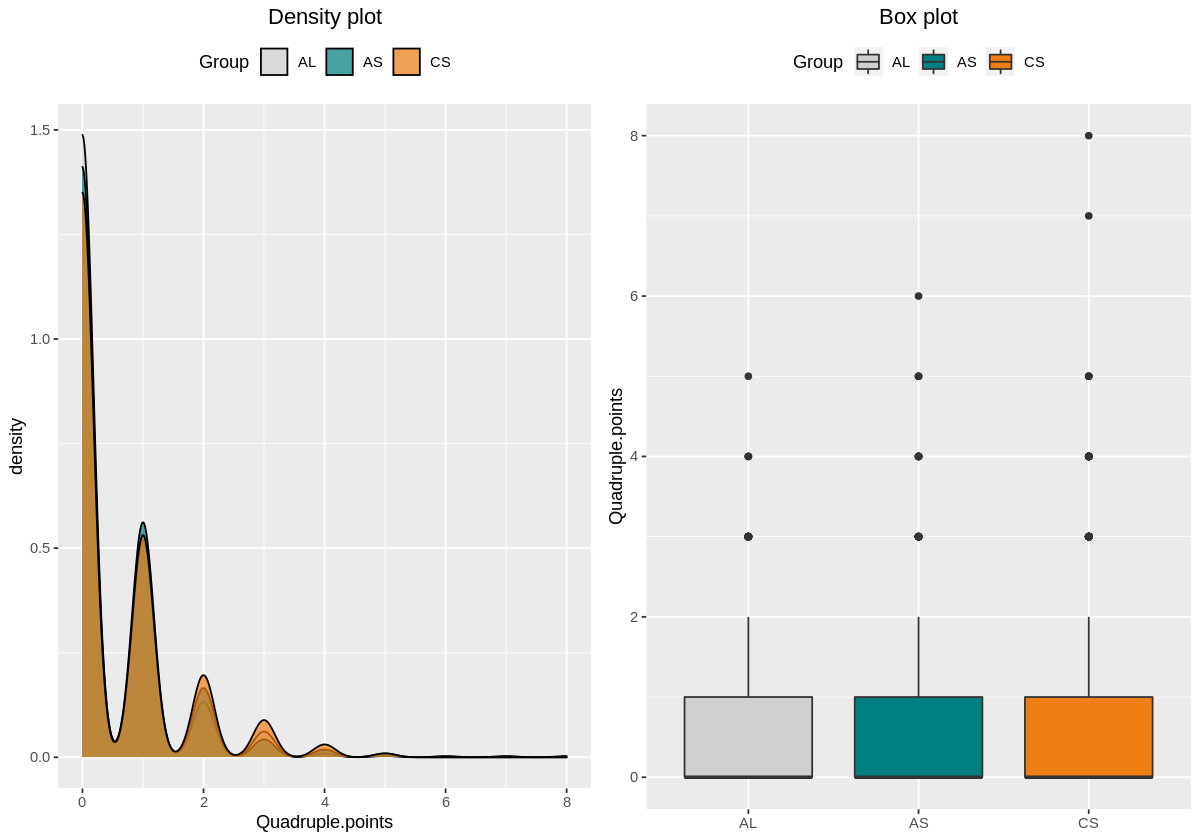

In [31]:
data.description <- mount.description(data,"Quadruple.points")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Quadruple.points")
p2 <- custom.box.plot(data, "Quadruple.points")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var  |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:-----:|:-----:|:---:|
|  CS   |  CA1   |  0   |    0    |   0    | 0.688 |    1    |  5   | 1.044 | 1.022 | 240 |
|  CS   |  CA3   |  0   |    0    |   0    | 0.542 |    1    |  7   | 0.810 | 0.900 | 240 |
|  CS   |   GD   |  0   |    0    |   0    | 0.679 |    1    |  8   | 1.256 | 1.121 | 240 |
|  AS   |  CA1   |  0   |    0    |   0    | 0.617 |    1    |  6   | 1.007 | 1.004 | 240 |
|  AS   |  CA3   |  0   |    0    |   0    | 0.529 |    1    |  4   | 0.685 | 0.828 | 240 |
|  AS   |   GD   |  0   |    0    |   0    | 0.429 |    1    |  5   | 0.522 | 0.723 | 240 |
|  AL   |  CA1   |  0   |    0    |   0    | 0.588 |    1    |  5   | 0.913 | 0.955 | 240 |
|  AL   |  CA3   |  0   |    0    |   0    | 0.371 |    1    |  3   | 0.418 | 0.647 | 240 |
|  AL   |   GD   |  0   |    0    |   0    | 0.425 |    1    |  4   | 0.488 | 

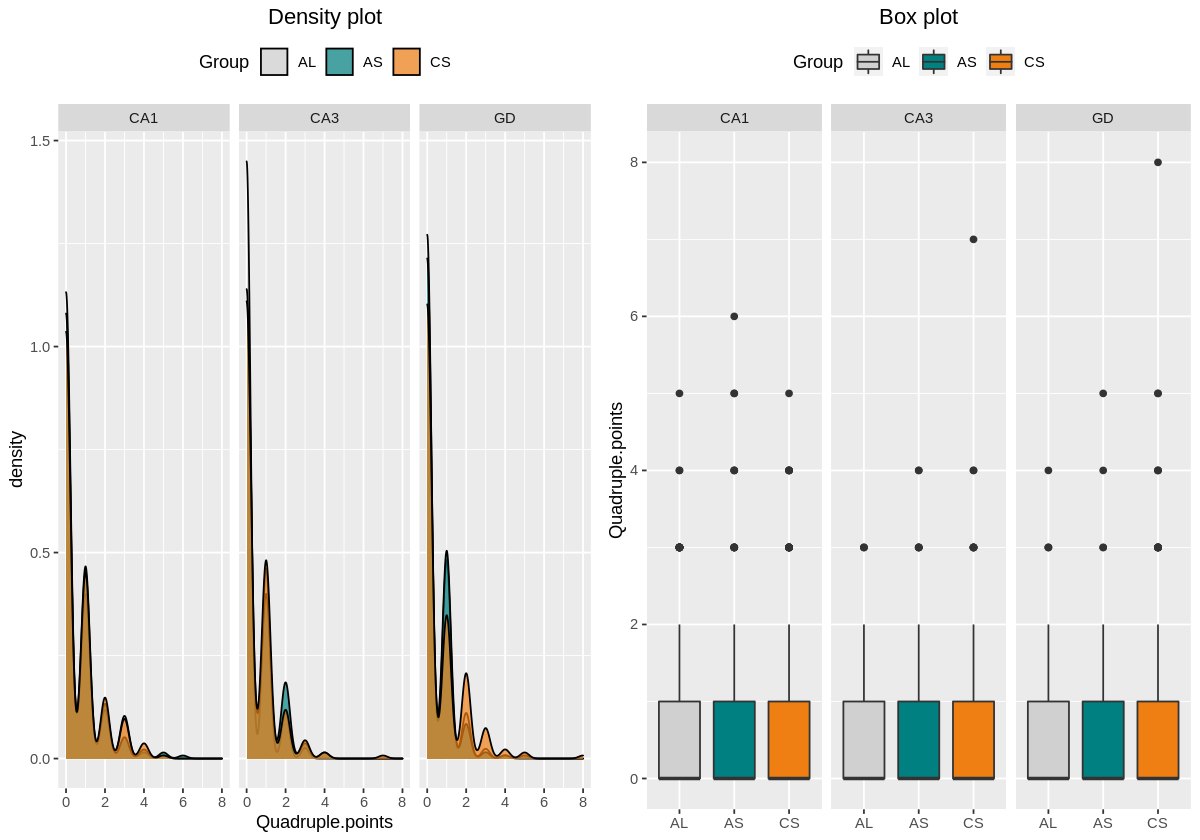

In [32]:
data.description <- mount.description(data, "Quadruple.points", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Quadruple.points", region = TRUE)
p2 <- custom.box.plot(data, "Quadruple.points", region = TRUE)

multiplot(p1,p2,cols = 2)

### End points
A description of the parameter.

#### Hippocampus



| Grupo | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  1   |    4    |   6    | 7.406 |    9    |  29  | 22.364 | 4.729 | 720 |
|  AS   |  1   |    3    |   6    | 6.497 |    8    |  25  | 16.242 | 4.030 | 720 |
|  AL   |  0   |    3    |   5    | 5.900 |    8    |  19  | 10.443 | 3.232 | 720 |

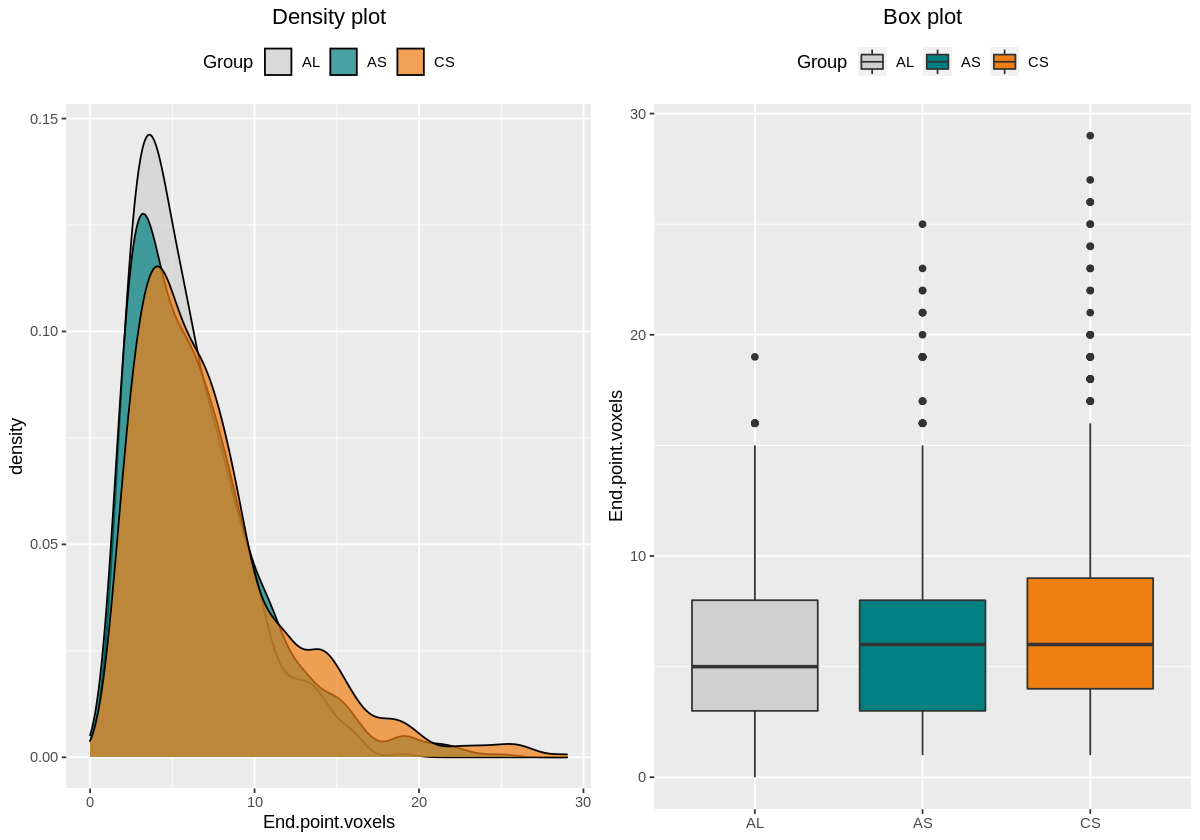

In [33]:
data.description <- mount.description(data,"End.point.voxels")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "End.point.voxels")
p2 <- custom.box.plot(data, "End.point.voxels")

multiplot(p1,p2,cols = 2)


#### Regions



| Grupo | Região | Min. | 1st Qu. | Median | Mean  | 3rd Qu. | Max. |  Var   |  Sd   |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-----:|:-------:|:----:|:------:|:-----:|:---:|
|  CS   |  CA1   |  1   |  4.00   |  6.5   | 7.800 |   10    |  27  | 27.056 | 5.202 | 240 |
|  CS   |  CA3   |  1   |  4.00   |  6.0   | 7.367 |    9    |  25  | 19.396 | 4.404 | 240 |
|  CS   |   GD   |  2   |  4.00   |  6.0   | 7.050 |    9    |  29  | 20.541 | 4.532 | 240 |
|  AS   |  CA1   |  1   |  3.75   |  6.0   | 6.838 |    9    |  25  | 19.609 | 4.428 | 240 |
|  AS   |  CA3   |  2   |  3.00   |  6.0   | 6.529 |    9    |  21  | 15.129 | 3.890 | 240 |
|  AS   |   GD   |  2   |  3.00   |  5.0   | 6.125 |    8    |  22  | 13.867 | 3.724 | 240 |
|  AL   |  CA1   |  2   |  4.00   |  6.0   | 6.787 |    9    |  19  | 12.846 | 3.584 | 240 |
|  AL   |  CA3   |  1   |  3.00   |  4.0   | 5.308 |    7    |  16  | 9.110  | 3.018 | 240 |
|  AL   |   GD   |  0   |  3.00   |  5.0   | 5.604 |    7    |  14  

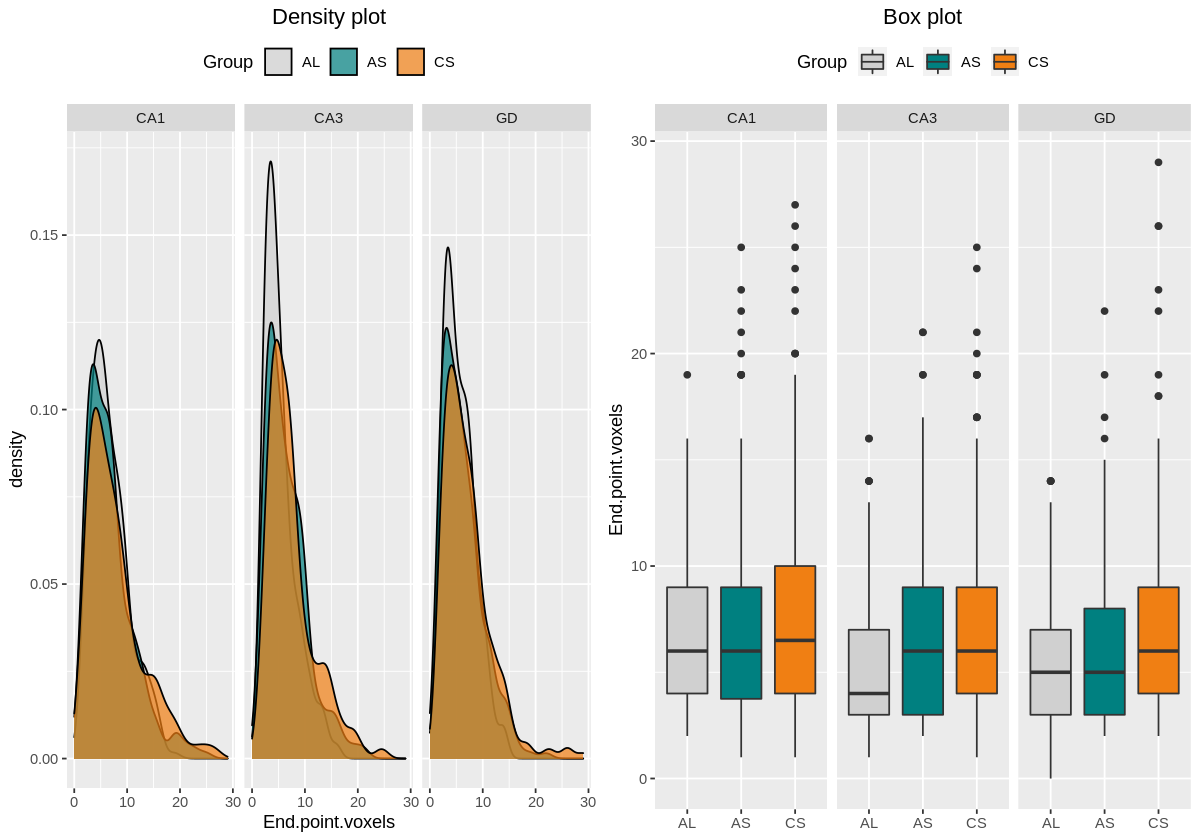

In [34]:
data.description <- mount.description(data, "End.point.voxels", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"End.point.voxels", region = TRUE)
p2 <- custom.box.plot(data, "End.point.voxels", region = TRUE)

multiplot(p1,p2,cols = 2)

### Average Branch Length
A description of the parameter.

#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   | 4.748 | 11.263  | 13.292 | 15.431 | 16.564  | 121.296 | 72.709  | 8.527  | 720 |
|  AS   | 1.414 | 11.064  | 13.254 | 15.775 | 17.035  | 66.698  | 75.828  | 8.708  | 720 |
|  AL   | 2.414 | 10.942  | 13.361 | 16.209 | 17.017  | 100.083 | 101.711 | 10.085 | 720 |

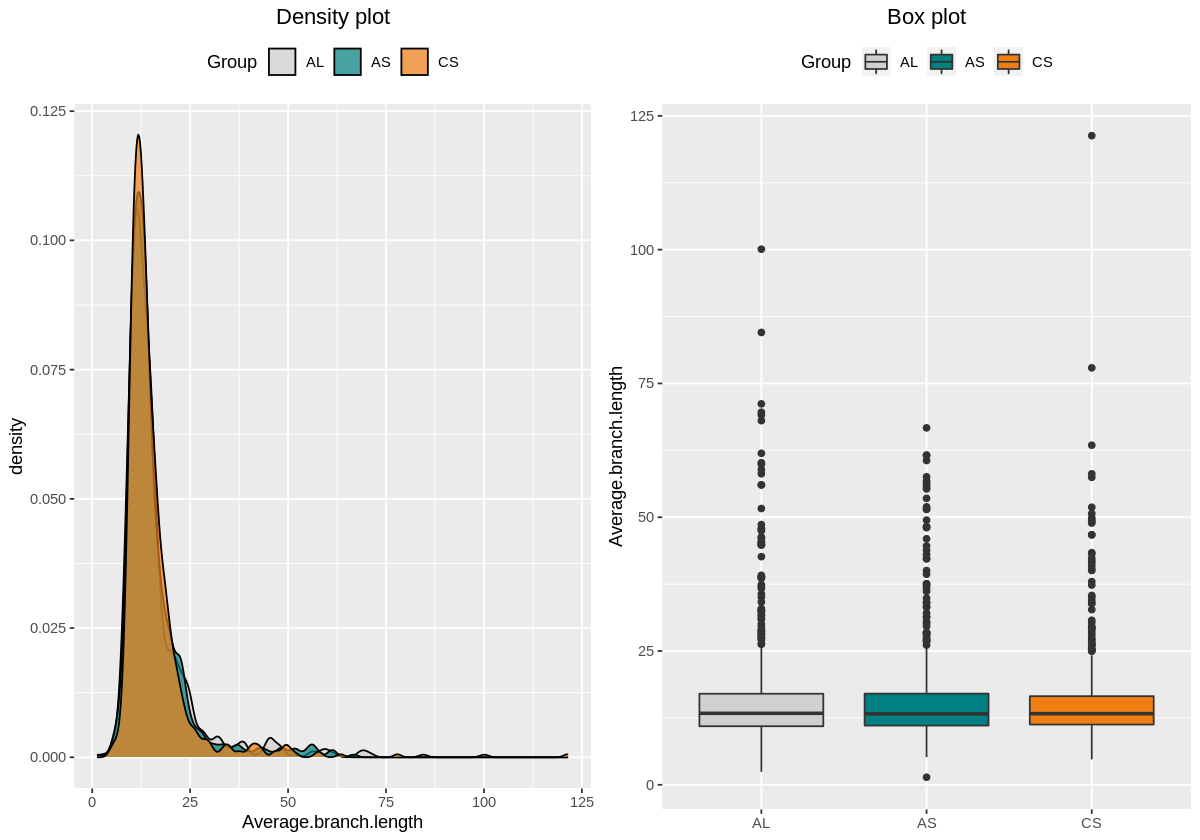

In [35]:
data.description <- mount.description(data,"Average.branch.length")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Average.branch.length")
p2 <- custom.box.plot(data, "Average.branch.length")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:------:|:-----:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   |  CA1   | 6.690 | 10.979  | 13.063 | 16.224 | 17.127  | 121.296 | 123.382 | 11.108 | 240 |
|  CS   |  CA3   | 4.748 | 11.639  | 13.825 | 14.979 | 16.728  | 58.113  | 31.205  | 5.586  | 240 |
|  CS   |   GD   | 5.552 | 10.830  | 12.696 | 15.092 | 16.110  | 63.456  | 63.198  | 7.950  | 240 |
|  AS   |  CA1   | 5.243 | 11.269  | 13.472 | 16.012 | 18.415  | 61.627  | 63.239  | 7.952  | 240 |
|  AS   |  CA3   | 5.414 | 10.868  | 13.195 | 15.628 | 16.941  | 57.556  | 68.720  | 8.290  | 240 |
|  AS   |   GD   | 1.414 | 10.945  | 13.020 | 15.685 | 16.061  | 66.698  | 96.074  | 9.802  | 240 |
|  AL   |  CA1   | 7.427 | 10.867  | 12.553 | 15.768 | 16.064  | 100.083 | 110.316 | 10.503 | 240 |
|  AL   |  CA3   | 2.414 | 11.153  | 14.023 | 17.211 | 17.778  | 84.527  | 117.181 | 10.825 | 240 

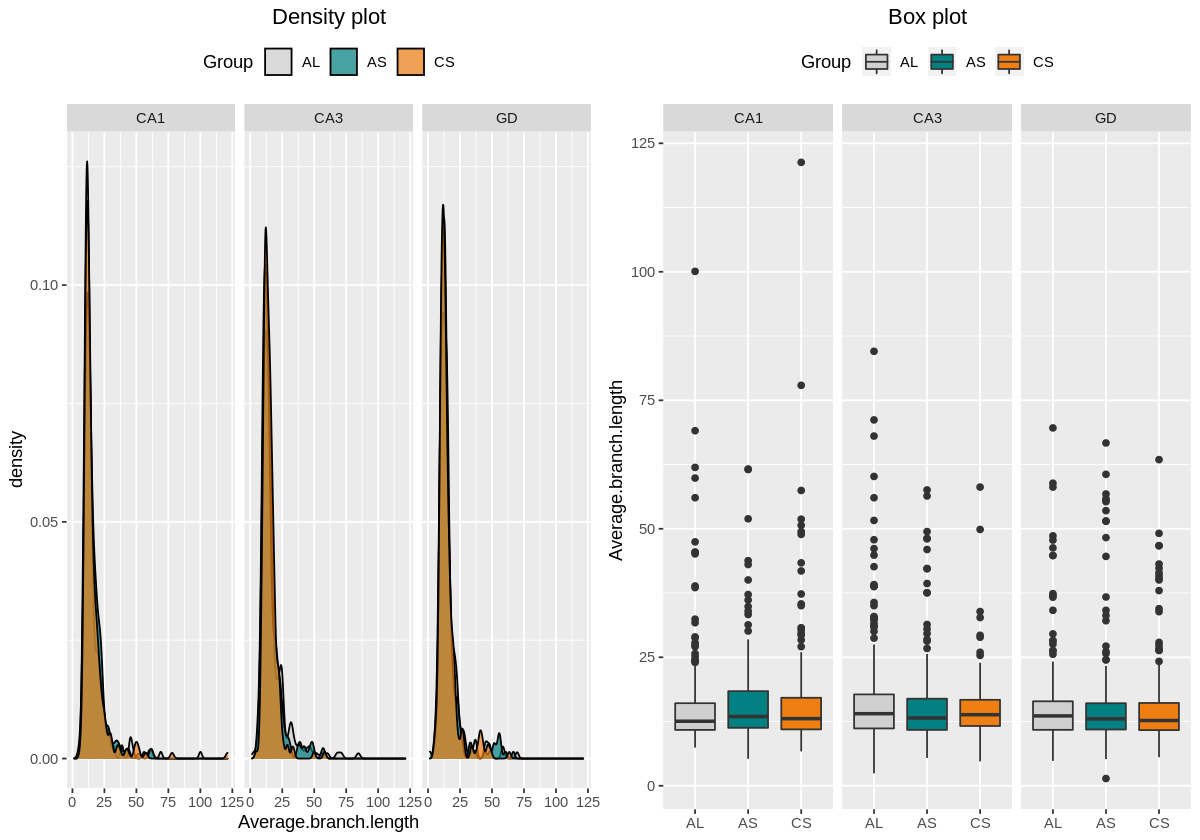

In [36]:
data.description <- mount.description(data, "Average.branch.length", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Average.branch.length", region = TRUE)
p2 <- custom.box.plot(data, "Average.branch.length", region = TRUE)

multiplot(p1,p2,cols = 2)

### Maximum Branch Length
A description of the parameter.

#### Hippocampus



| Grupo | Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:-----:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   | 6.828 | 23.314  | 29.703 | 32.473 | 37.556  | 131.468 | 202.092 | 14.216 | 720 |
|  AS   | 1.414 | 22.442  | 28.556 | 30.723 | 36.599  | 103.497 | 151.590 | 12.312 | 720 |
|  AL   | 2.414 | 21.899  | 27.688 | 30.417 | 35.971  | 118.054 | 162.678 | 12.755 | 720 |

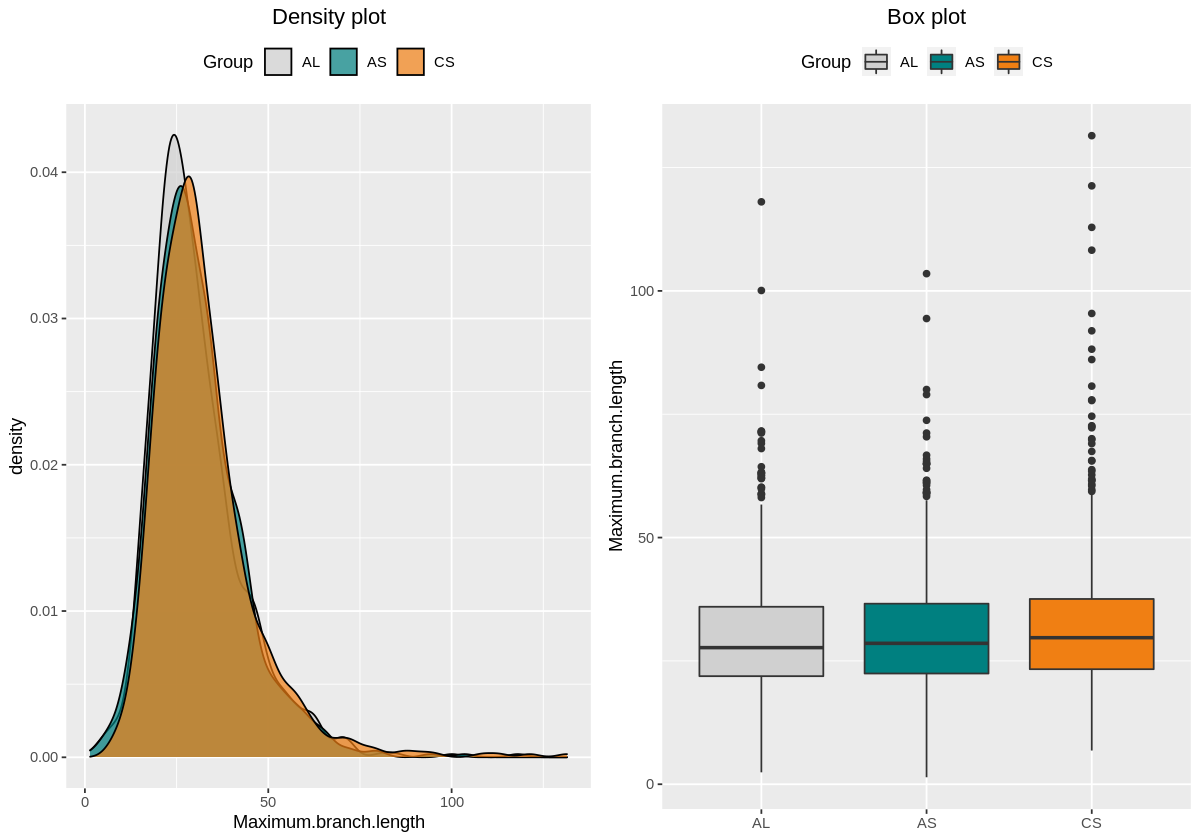

In [37]:
data.description <- mount.description(data,"Maximum.branch.length")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Maximum.branch.length")
p2 <- custom.box.plot(data, "Maximum.branch.length")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região |  Min.  | 1st Qu. | Median |  Mean  | 3rd Qu. |  Max.   |   Var   |   Sd   |  N  |
|:-----:|:------:|:------:|:-------:|:------:|:------:|:-------:|:-------:|:-------:|:------:|:---:|
|  CS   |  CA1   | 9.243  | 23.728  | 29.971 | 33.976 | 40.014  | 131.468 | 261.505 | 16.171 | 240 |
|  CS   |  CA3   | 9.414  | 24.728  | 30.520 | 32.826 | 38.385  | 86.083  | 138.758 | 11.780 | 240 |
|  CS   |   GD   | 6.828  | 21.399  | 28.521 | 30.617 | 36.728  | 112.882 | 201.850 | 14.207 | 240 |
|  AS   |  CA1   | 5.243  | 23.485  | 30.264 | 31.467 | 37.299  | 94.397  | 138.738 | 11.779 | 240 |
|  AS   |  CA3   | 5.414  | 22.314  | 28.556 | 31.027 | 37.615  | 103.497 | 159.401 | 12.625 | 240 |
|  AS   |   GD   | 1.414  | 21.071  | 27.814 | 29.674 | 35.213  | 80.012  | 156.147 | 12.496 | 240 |
|  AL   |  CA1   | 10.071 | 23.142  | 28.142 | 30.542 | 36.057  | 100.083 | 129.603 | 11.384 | 240 |
|  AL   |  CA3   | 2.414  | 21.728  | 27.264 | 30.605 | 35.739  | 118.054 | 204.906 | 14.

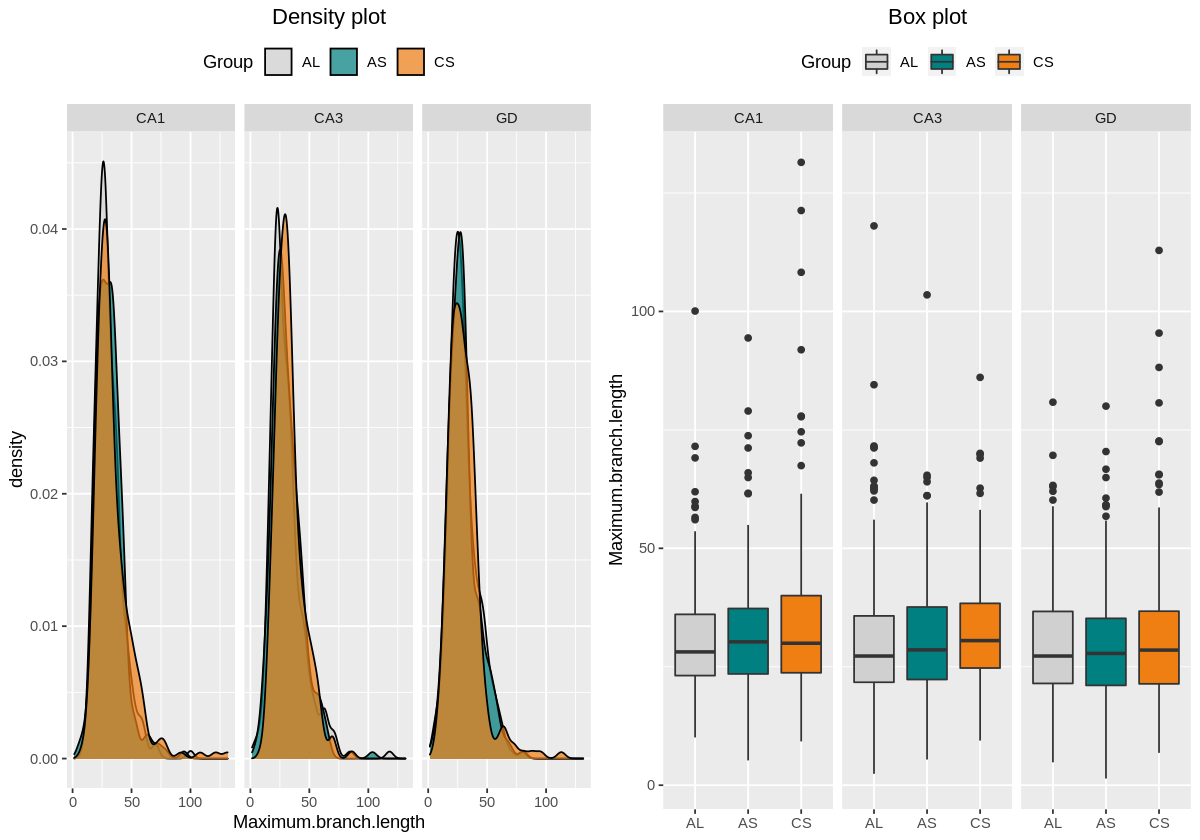

In [38]:
data.description <- mount.description(data, "Maximum.branch.length", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Maximum.branch.length", region = TRUE)
p2 <- custom.box.plot(data, "Maximum.branch.length", region = TRUE)

multiplot(p1,p2,cols = 2)

### D (Fractal Dimension)
A description of the parameter.

#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  1   | 496.75  | 902.5  | 875.254 | 1244.00 | 1688 | 203087.9 | 450.653 | 720 |
|  AS   |  3   | 533.75  | 904.5  | 878.235 | 1261.25 | 1687 | 201257.5 | 448.617 | 720 |
|  AL   |  2   | 470.25  | 809.0  | 813.515 | 1139.25 | 1684 | 175856.2 | 419.352 | 720 |

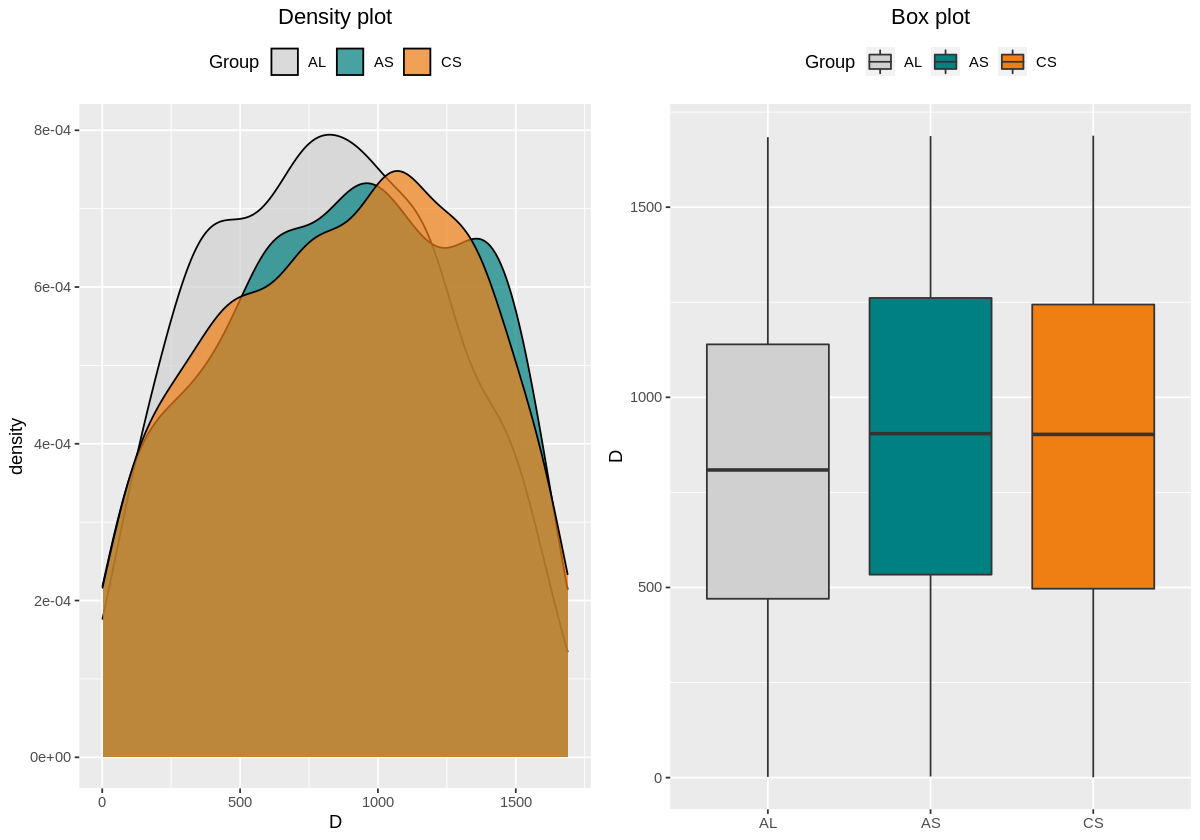

In [39]:
data.description <- mount.description(data,"D")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "D")
p2 <- custom.box.plot(data, "D")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  CA1   |  1   | 440.25  | 826.0  | 827.921 | 1217.75 | 1688 | 223893.0 | 473.173 | 240 |
|  CS   |  CA3   |  46  | 494.75  | 832.0  | 847.525 | 1200.00 | 1685 | 178002.7 | 421.904 | 240 |
|  CS   |   GD   |  9   | 622.25  | 1015.5 | 950.317 | 1302.25 | 1682 | 200387.5 | 447.647 | 240 |
|  AS   |  CA1   |  7   | 551.25  | 867.0  | 881.742 | 1255.50 | 1676 | 206546.7 | 454.474 | 240 |
|  AS   |  CA3   |  15  | 471.75  | 874.5  | 851.342 | 1254.25 | 1687 | 211294.3 | 459.668 | 240 |
|  AS   |   GD   |  3   | 545.75  | 939.0  | 901.621 | 1268.00 | 1664 | 186327.7 | 431.657 | 240 |
|  AL   |  CA1   |  36  | 396.25  | 765.0  | 765.538 | 1123.25 | 1678 | 187466.1 | 432.974 | 240 |
|  AL   |  CA3   |  2   | 512.00  | 840.0  | 823.796 | 1164.75 | 1681 | 174486.1 | 417.715 | 240 |
|  AL   

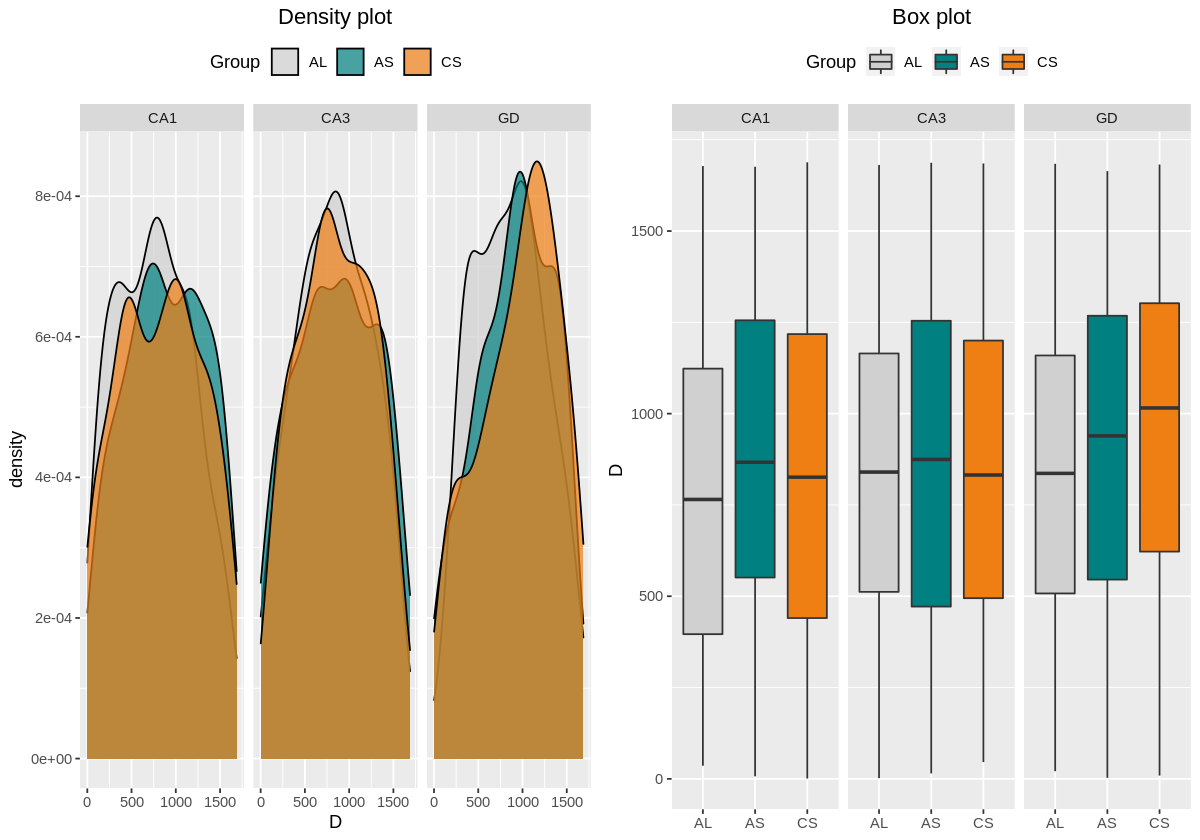

In [40]:
data.description <- mount.description(data, "D", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"D", region = TRUE)
p2 <- custom.box.plot(data, "D", region = TRUE)

multiplot(p1,p2,cols = 2)

### Lacunarity
A description of the parameter.

#### Hippocampus



| Grupo | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  11  | 530.75  | 937.5  | 915.658 | 1282.00 | 1793 | 226457.6 | 475.876 | 720 |
|  AS   |  4   | 453.25  | 893.5  | 897.692 | 1335.75 | 1799 | 255037.4 | 505.012 | 720 |
|  AL   |  2   | 500.50  | 900.5  | 881.487 | 1252.50 | 1794 | 216290.0 | 465.070 | 720 |

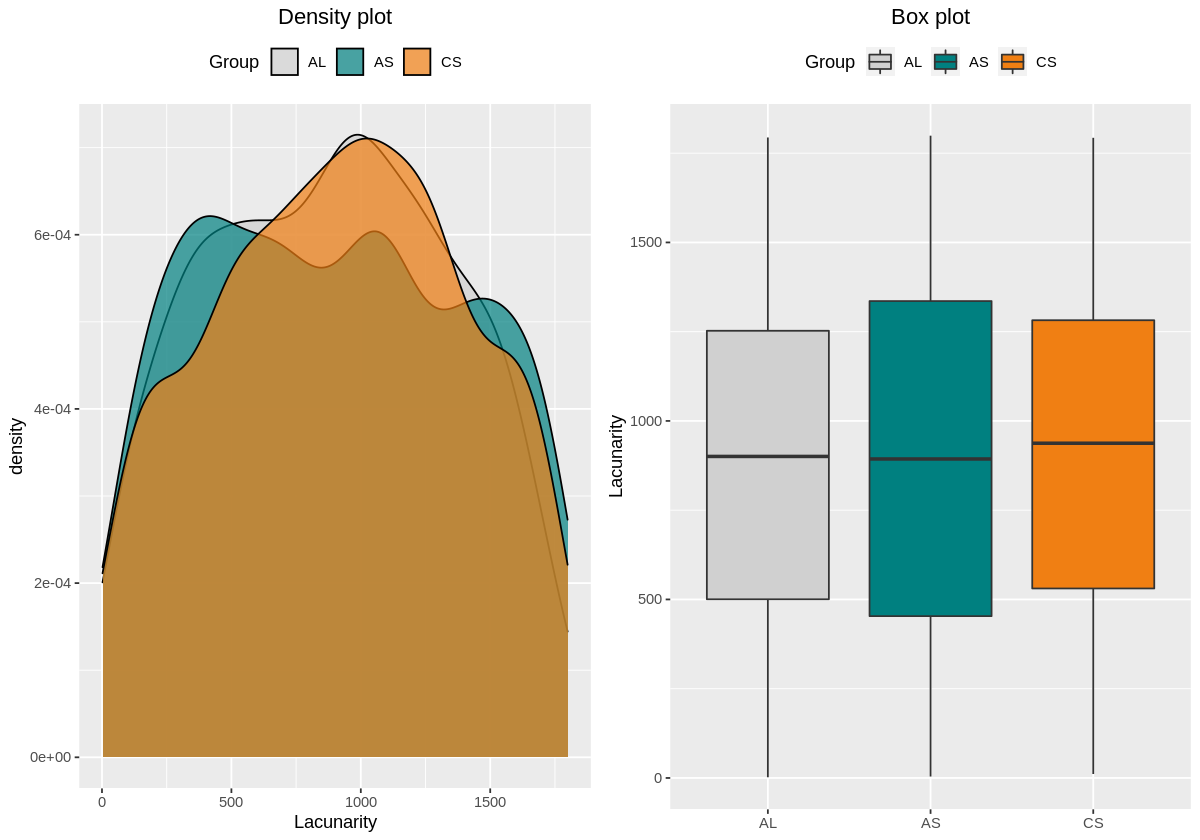

In [41]:
data.description <- mount.description(data,"Lacunarity")

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data, "Lacunarity")
p2 <- custom.box.plot(data, "Lacunarity")

multiplot(p1,p2,cols = 2)

#### Regions



| Grupo | Região | Min. | 1st Qu. | Median |  Mean   | 3rd Qu. | Max. |   Var    |   Sd    |  N  |
|:-----:|:------:|:----:|:-------:|:------:|:-------:|:-------:|:----:|:--------:|:-------:|:---:|
|  CS   |  CA1   |  11  | 588.00  | 967.0  | 939.396 | 1285.75 | 1786 | 217727.5 | 466.613 | 240 |
|  CS   |  CA3   |  38  | 590.00  | 998.0  | 942.638 | 1275.75 | 1793 | 209765.2 | 458.001 | 240 |
|  CS   |   GD   |  20  | 489.25  | 837.5  | 864.942 | 1280.00 | 1790 | 249895.7 | 499.896 | 240 |
|  AS   |  CA1   |  4   | 524.00  | 920.0  | 942.192 | 1386.25 | 1799 | 260560.7 | 510.451 | 240 |
|  AS   |  CA3   |  12  | 513.50  | 889.5  | 912.962 | 1342.25 | 1791 | 253475.2 | 503.463 | 240 |
|  AS   |   GD   |  43  | 377.50  | 849.5  | 837.921 | 1192.25 | 1797 | 247400.1 | 497.393 | 240 |
|  AL   |  CA1   |  51  | 615.00  | 1014.0 | 986.354 | 1361.25 | 1794 | 210640.2 | 458.956 | 240 |
|  AL   |  CA3   |  3   | 436.75  | 764.0  | 806.208 | 1153.00 | 1764 | 209330.0 | 457.526 | 240 |
|  AL   

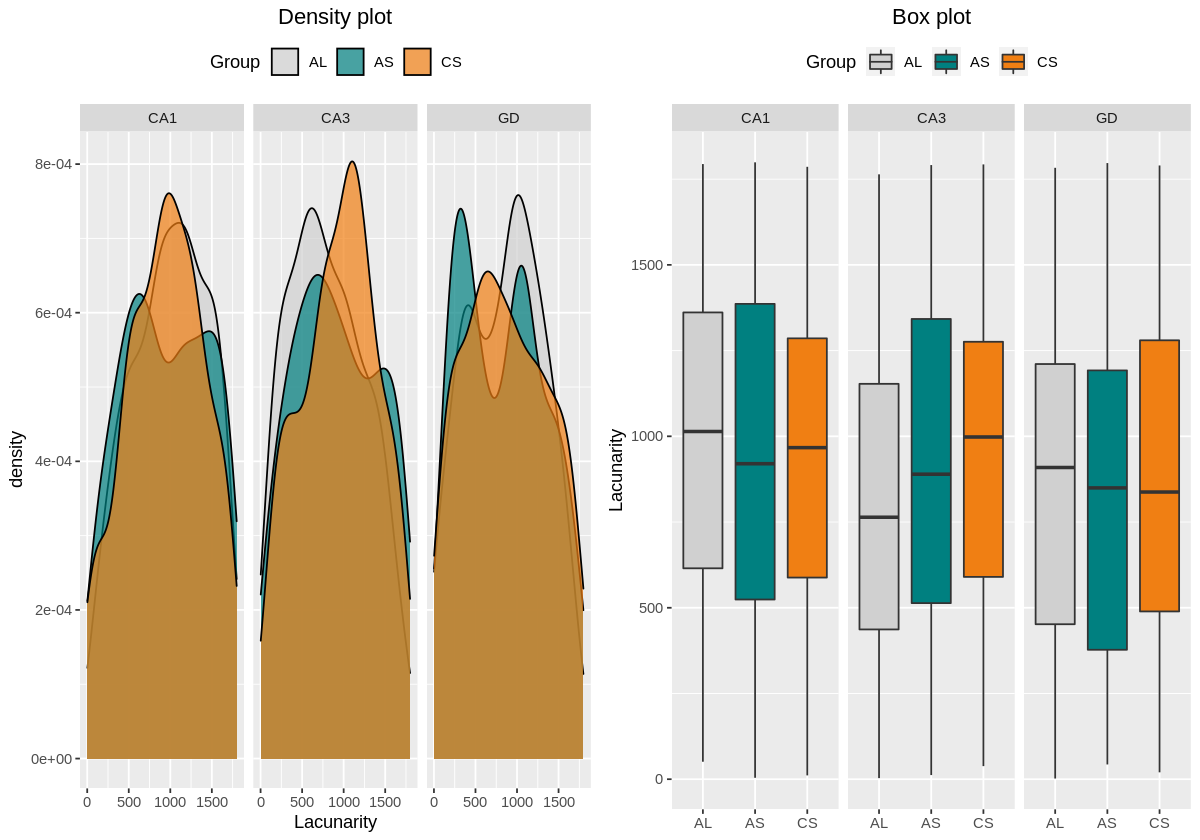

In [42]:
data.description <- mount.description(data, "Lacunarity", region = TRUE)

knitr::kable(data.description, align = "c",digits = c(0,3,3,3,3,3,3,3,3,3))

p1 <- custom.density.plot(data,"Lacunarity", region = TRUE)
p2 <- custom.box.plot(data, "Lacunarity", region = TRUE)

multiplot(p1,p2,cols = 2)

## Observations

Here I can describe some points to take note off

- variance variablitiy by experimental group (CS2!!)

- Number of cells outside hipocampos in each group (impact on CS2)